In [0]:
import pandas as pd
import numpy as np
import keras
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.callbacks.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import fowlkes_mallows_score
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/Spatio temporal/Tabitha/example2.csv")

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700000 entries, 0 to 2699999
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      float64
 1   Time    int64  
 2   x       int64  
 3   y       int64  
 4   label   int64  
dtypes: float64(1), int64(4)
memory usage: 103.0 MB


In [0]:
grouped = data.groupby("id")

In [0]:
grouped.size()

id
1.1      3000
1.2      3000
1.3      3000
1.4      3000
1.5      3000
         ... 
100.5    3000
100.6    3000
100.7    3000
100.8    3000
100.9    3000
Length: 900, dtype: int64

In [0]:
data.head()

,id,Time,x,y,label
0,1.1,1,650,8850,2
1,1.1,2,650,8750,2
2,1.1,3,750,8750,2
3,1.1,4,450,8450,2
4,1.1,5,750,8550,1


In [0]:
def get_xy_tensors(data, timestep):

    data.dropna(inplace = True)
    groupedpp = data.groupby("id", as_index = False)
    n = groupedpp.ngroups

    indices = np.arange(n)
    np.random.shuffle(indices)
    split = int(np.floor(n * 0.8))

    train_vis, test_vis = [], []

    array_train = np.zeros(shape = (split, timestep, 2))
    array_test = np.zeros(shape = (n - split, timestep, 2))

    train_index, test_index = 0, 0

    groundtruth_train, groundtruth_test = [], []

    scaler = StandardScaler().fit(data[["x", "y"]])
    
    for i, df in zip(indices, groupedpp):
      X = scaler.transform(df[1][["x", "y"]])
      truth = df[1].reset_index(drop = True).at[0, "label"]

      if i < split:
        array_train[train_index,:len(X),:] = X
        groundtruth_train.append(truth)
        train_vis.append(df[1])
        train_index += 1
      else:
        array_test[test_index,:len(X),:] = X
        groundtruth_test.append(truth)
        test_vis.append(df[1])
        test_index += 1
    return array_train, array_test, groundtruth_train, groundtruth_test, pd.concat(train_vis, ignore_index=True), pd.concat(test_vis, ignore_index=True)

In [0]:
def simple_lstm(time_dim, hidden_dim1, hidden_dim2, features):
    #Inputs
    encoder_input = Input(shape = (time_dim, features))
    
    #Put together encoder
    encoded1 = LSTM(hidden_dim1, return_sequences = True, activation= "tanh")(encoder_input)
    encoded2 = LSTM(hidden_dim2, return_sequences = False, activation = "tanh")(encoded1)
    #This generates the encoding vectors to use for clustering
    #encoded3 = LSTM(hidden_dim3, return_sequences = False)(encoded2)
        
    #format encoder output for the decoder input
    decoded = RepeatVector(time_dim)(encoded2)
    
    #Decoder is the inverse of the encoder
    #decoded1 = LSTM(hidden_dim3, return_sequences = True)(decoded)
    decoded2 = LSTM(hidden_dim2, return_sequences = True, activation = "tanh")(decoded)
    decoded3 = LSTM(hidden_dim1, return_sequences = True, activation = "tanh")(decoded2)
    
    #applies dense layer (shape becomes the same as output) independently to each timestep
    decoded4 = TimeDistributed(Dense(features))(decoded3)
    
    #autoencoder
    autoencoder = Model(encoder_input, decoded4)
    #encoder
    encoder = Model(encoder_input, encoded2)
    
    return autoencoder, encoder

In [0]:
def plot_clusters(data, labels, cluster, ax = None):
  ax = ax
  groupedpp = data.groupby("id")
  index = np.arange(groupedpp.ngroups)
  for i, df in zip(index, groupedpp):
    if labels[i] == cluster:
      ax.plot(df[1]["x"], df[1]["y"])
  return ax

In [0]:
groundtruth1 = data.groupby('id', as_index=False)[["label"]].first().drop("id", axis = 1).values.reshape(900,)

In [0]:
np.unique(groundtruth1)

array([1, 2, 3, 4])

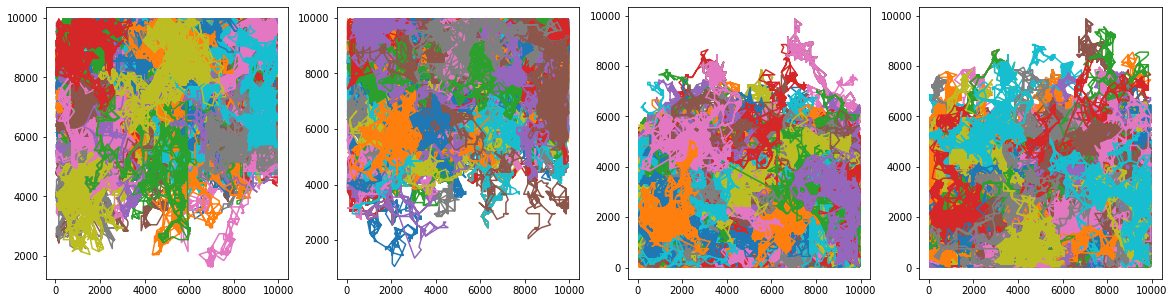

In [0]:
fig, ax = plt.subplots(1,4, figsize = (20, 5))
for i in range():
  plot_clusters(data, groundtruth1,i+1, ax[i])
plt.tight_layout
plt.show()

In [0]:
def create_X(df):
    groupedpp = df.groupby("id")
    array = np.zeros(shape = (900, 6000))
    index = 0
    for traj, df in groupedpp:
      df.dropna(inplace = True)
      array[index,:len(df)] = df[["x"]].values.reshape(len(df),)
      array[index,len(df):len(df)*2] = df[["y"]].values.reshape(len(df),)
      index += 1
    return array

In [0]:
baseline = create_X(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
baseline_scaled = StandardScaler().fit_transform(baseline)

In [0]:
kfit = KMeans(4).fit(baseline)
clusters = kfit.labels_

In [0]:
fowlkes_mallows_score(groundtruth1, clusters)

0.49487122689108903

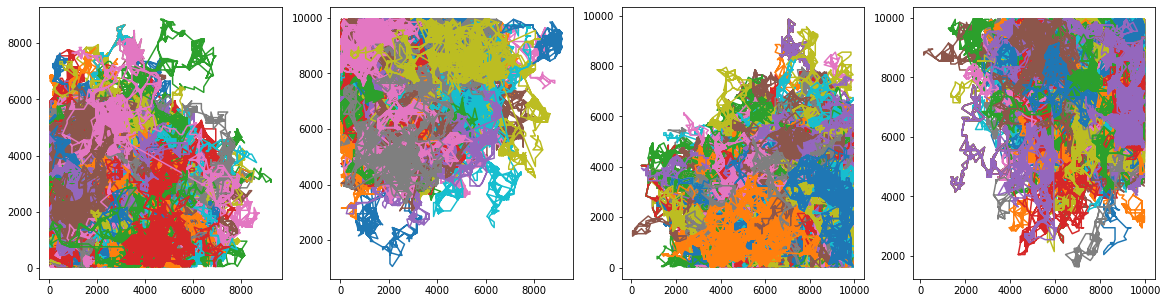

In [0]:
fig, ax = plt.subplots(1,4, figsize = (20, 5))
for i in range(4):
  plot_clusters(data, clusters,i, ax[i])
plt.tight_layout
plt.show()

In [0]:
def get_results(encoder, train, test, trainv, testv, gttrain, gttest):
  train_vecs = encoder.predict(train)
  test_vecs = encoder.predict(test)

  kfit_train = KMeans(n_clusters = 4).fit(train_vecs)
  kfit_test = KMeans(n_clusters = 4).fit(test_vecs)
  
  cluster_labels_train = kfit_train.labels_
  cluster_labels_test = kfit_test.labels_

  fscore_train = fowlkes_mallows_score(gttrain, cluster_labels_train)
  fscore_test = fowlkes_mallows_score(gttest, cluster_labels_test)

  fig, ax = plt.subplots(1,4, figsize = (20, 5))
  for i in range(4):
    plot_clusters(trainv, cluster_labels_train,i, ax[i])
  plt.tight_layout
  plt.show()

  print("fowlkes mallows score training set:",fscore_train)

  fig, ax = plt.subplots(1,4, figsize = (20, 5))
  for i in range(4):
    plot_clusters(testv, cluster_labels_test, i, ax[i])
  plt.tight_layout
  plt.show()

  print("fowlkes mallows score test set:",fscore_test)

In [0]:
tensor_train,tensor_test, groundtruth_train, groundtruth_test, vis_train, vis_test = get_xy_tensors(data, 3000)

In [0]:
from tensorflow.keras.models import load_model
encoder_2 = load_model('/content/lstm2encoderst-3.h5', compile = False)

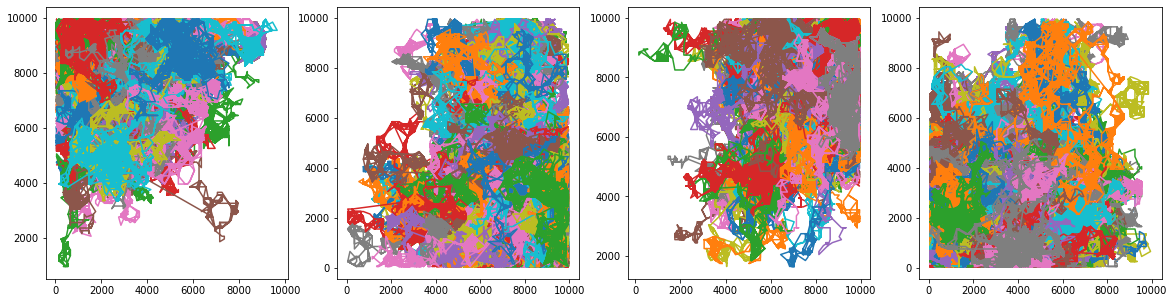

fowlkes mallows score training set: 0.43931101799712013


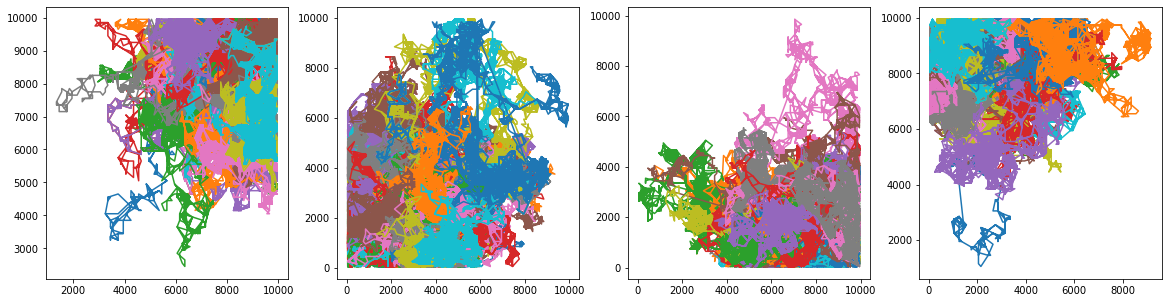

fowlkes mallows score test set: 0.4728591009232283


In [0]:
get_results(encoder_2, tensor_train, tensor_test, vis_train, vis_test, groundtruth_train, groundtruth_test)

In [0]:
encoder_4 = load_model('/content/encoder_4.h5', compile = False)

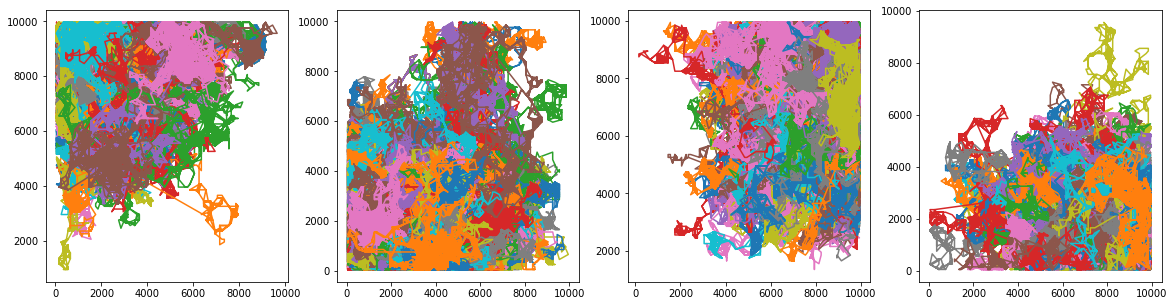

fowlkes mallows score training set: 0.4285889451711838


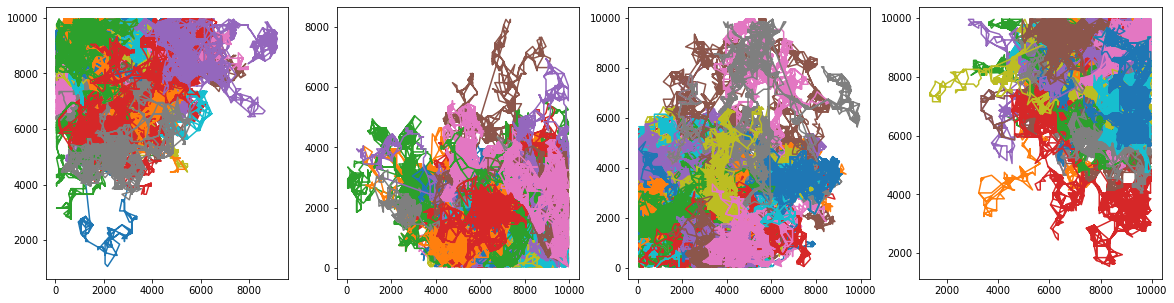

fowlkes mallows score test set: 0.4844404414451328


In [0]:
get_results(encoder_4, tensor_train, tensor_test, vis_train, vis_test, groundtruth_train, groundtruth_test)

In [0]:
autoencoder_2, encoder_2 = simple_lstm(3000, 128, 64, 2)

In [0]:
#A decaying learning rate may work better
#opt = keras.optimizers.Adam(learning_rate=0.01)
cb = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
autoencoder_2.compile(optimizer = "adam", loss = "mse", metrics=['accuracy'])
autoencoder_2.fit(tensor_train, tensor_train, verbose = 1, epochs = 50, validation_split = 0.2, batch_size = 100, callbacks=[cb])

Train on 576 samples, validate on 144 samples
Epoch 1/50
576/576 [==============================] - 121s 209ms/step - loss: 0.5985 - accuracy: 0.7088 - val_loss: 0.3349 - val_accuracy: 0.8518
Epoch 2/50
576/576 [==============================] - 119s 207ms/step - loss: 0.2766 - accuracy: 0.8243 - val_loss: 0.2267 - val_accuracy: 0.8088
Epoch 3/50
576/576 [==============================] - 119s 207ms/step - loss: 0.2455 - accuracy: 0.7938 - val_loss: 0.2378 - val_accuracy: 0.7998
Epoch 4/50
576/576 [==============================] - 121s 209ms/step - loss: 0.2206 - accuracy: 0.8096 - val_loss: 0.2254 - val_accuracy: 0.8534
Epoch 5/50
576/576 [==============================] - 118s 205ms/step - loss: 0.2110 - accuracy: 0.8184 - val_loss: 0.2153 - val_accuracy: 0.7998
Epoch 6/50
576/576 [==============================] - 121s 211ms/step - loss: 0.2089 - accuracy: 0.8118 - val_loss: 0.2015 - val_accuracy: 0.8406
Epoch 7/50
576/576 [==============================] - 121s 211ms/step - loss: 

In [0]:
autoencoder_2.save("lstm2autoencoders_2.h5")
encoder_2.save("lstm2encoders_2.h5")

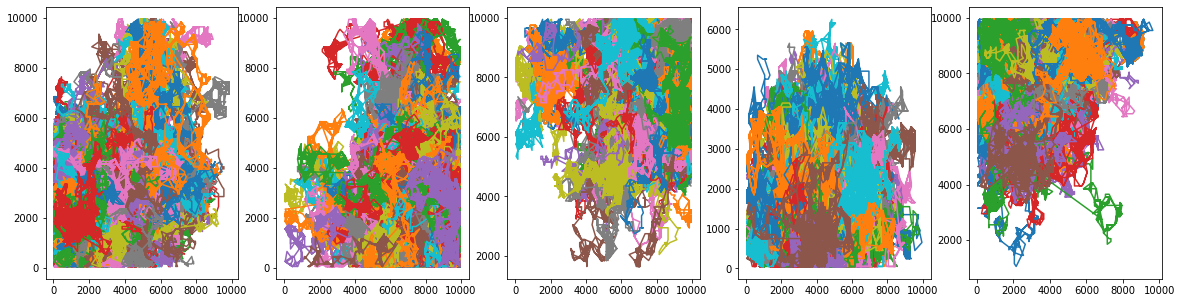

fowlkes mallows score training set: 0.4168651016448074


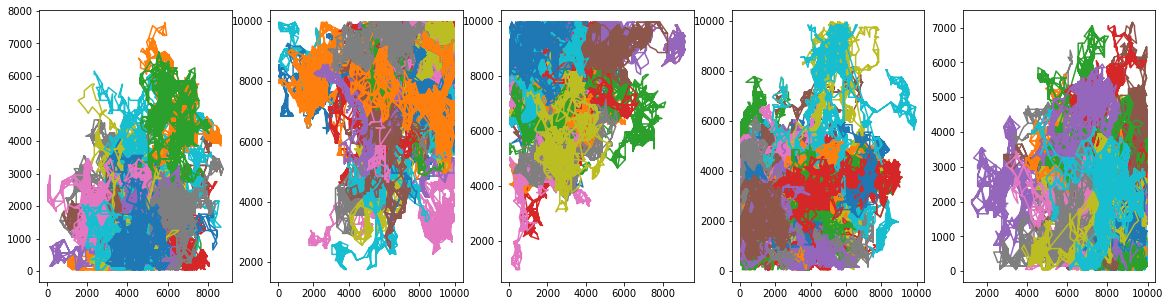

fowlkes mallows score test set: 0.3948186661182833


In [0]:
get_results(encoder_2, tensor_train, tensor_test, vis_train, vis_test, groundtruth_train, groundtruth_test)

In [0]:
def layer_lstm(time_dim, features):
    #Inputs
    encoder_input = Input(shape = (time_dim, features))
    
    #Put together encoder
    encoded1 = LSTM(64, return_sequences = True, activation= "tanh")(encoder_input)
    encoded2 = LSTM(32, return_sequences = True, activation = "tanh")(encoded1)
    encoded3 = LSTM(16, return_sequences = True, activation = "tanh")(encoded2)
    encoded4 = LSTM(8, return_sequences = False, activation = "tanh")(encoded3)
    #This generates the encoding vectors to use for clustering
    #encoded3 = LSTM(hidden_dim3, return_sequences = False)(encoded2)
        
    #format encoder output for the decoder input
    decoded = RepeatVector(time_dim)(encoded4)
    
    #Decoder is the inverse of the encoder
    decoded2 = LSTM(8, return_sequences = True, activation = "tanh")(decoded)
    decoded3 = LSTM(16, return_sequences = True, activation = "tanh")(decoded2)
    decoded4 = LSTM(32, return_sequences = True, activation = "tanh")(decoded3)
    decoded5 = LSTM(64, return_sequences = True, activation = "tanh")(decoded4)

    #applies dense layer (shape becomes the same as output) independently to each timestep
    decoded_final = TimeDistributed(Dense(features))(decoded5)
    
    #autoencoder
    autoencoder = Model(encoder_input, decoded_final)
    #encoder
    encoder = Model(encoder_input, encoded4)
    
    return autoencoder, encoder

In [0]:
autoencoder_5, encoder_5 = layer_lstm(3000, 2)

In [0]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=0.0001)
cb = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)
autoencoder_5.compile(optimizer = opt, loss = "mse", metrics=['accuracy'])
autoencoder_5.fit(tensor_train, tensor_train, verbose = 1, epochs = 50, validation_split = 0.2, batch_size = 100, callbacks=[cb])

Train on 576 samples, validate on 144 samples
Epoch 1/50
576/576 [==============================] - 257s 447ms/step - loss: 0.9675 - accuracy: 0.4314 - val_loss: 1.1212 - val_accuracy: 0.5954
Epoch 2/50
576/576 [==============================] - 252s 438ms/step - loss: 0.9600 - accuracy: 0.5280 - val_loss: 1.1180 - val_accuracy: 0.6009
Epoch 3/50
576/576 [==============================] - 254s 441ms/step - loss: 0.9547 - accuracy: 0.6407 - val_loss: 1.1148 - val_accuracy: 0.7987
Epoch 4/50
576/576 [==============================] - 257s 446ms/step - loss: 0.9491 - accuracy: 0.7228 - val_loss: 1.1094 - val_accuracy: 0.7992
Epoch 5/50
576/576 [==============================] - 254s 442ms/step - loss: 0.9410 - accuracy: 0.7864 - val_loss: 1.1003 - val_accuracy: 0.7995
Epoch 6/50
576/576 [==============================] - 256s 445ms/step - loss: 0.9290 - accuracy: 0.7906 - val_loss: 1.0869 - val_accuracy: 0.8405
Epoch 7/50
576/576 [==============================] - 253s 440ms/step - loss: 

In [0]:
autoencoder_5.save("autoencoder_4.h5")
encoder_5.save("encoder_4.h5")

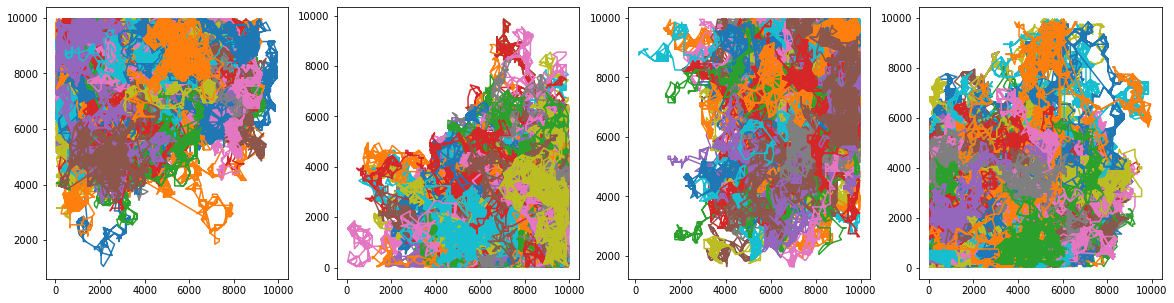

fowlkes mallows score training set: 0.44495182418699863


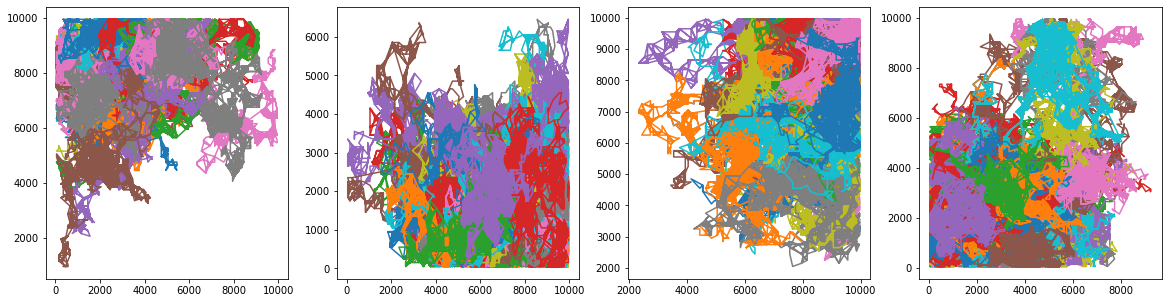

fowlkes mallows score test set: 0.4406434000079544


In [0]:
get_results(encoder_5, tensor_train, tensor_test, vis_train, vis_test, groundtruth_train, groundtruth_test)